In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random
import datetime
import scipy.cluster.hierarchy as sch

from mlfinlab.portfolio_optimization.hrp import HierarchicalRiskParity
from pypfopt import expected_returns, risk_models
from pypfopt import EfficientFrontier
from pypfopt import HRPOpt

In [2]:
dataset = pd.read_excel('./Bloomberg_DRL.xlsx', sheet_name = 'Data',index_col='Date')
# dataset['UST_JPY'] = dataset['SPBDU10T Index'] * dataset['JPY BGN Curncy']
# dataset['SPX_JPY'] = dataset['SPXT Index'] * dataset['JPY BGN Curncy']

In [3]:
# すべて現地通貨建て(先物で執行前提)
target_name = ['SPBDU10T Index', 'SPXT Index', 'TPXDDVD Index', 'SPJGBTR Index', 'SX5E Index', 'MXEF Index', 'SHCOMP Index', 'HSI Index', 'ASX Index',
               'XAU BGN Curncy', 'CL1 COMB Comdty', 'HG1 COMB Comdty']

In [4]:
dataset.columns

Index(['SPX Index', 'SX5E Index', 'TPX Index', 'MXEF Index', 'SHCOMP Index',
       'HSI Index', 'ASX Index', 'JPY BGN Curncy', 'EUR BGN Curncy',
       'GBP BGN Curncy', 'AUD BGN Curncy', 'CAD BGN Curncy', 'MXN BGN Curncy',
       'CNY BGN Curncy', 'VIX Index', 'MOVE Index', 'CESIUSD index',
       'CESIEUR index', 'CBT42NCN index', 'CBT55NCN index', 'CBT4TNCN Index',
       'CBT3TNCN Index', 'USGG2YR Index', 'USGG5YR Index', 'USGG10YR Index',
       'USGG30YR Index', 'GDBR2 Index', 'GDBR5 Index', 'GDBR10 Index',
       'GDBR30 Index', 'GJGB2 index', 'GJGB5 index', 'GJGB10 index',
       'GJGB30 index', 'XAU BGN Curncy', 'CL1 COMB Comdty', 'HG1 COMB Comdty',
       'LUCROAS Index', 'LECPOAS Index', 'USGG5Y5Y Index', 'IMM5JNCN Index',
       'IMMBENCN Index', 'IMM6ANCN Index', 'IMM5PNCN Index', 'IMM6MNCN Index',
       'IMM3CNCN Index', 'CESIEM Index', 'CESIJPY Index', 'CESIGL Index',
       'SPBDU10T Index', 'SPXT Index', 'TPXDDVD Index', 'SPJGBTR Index'],
      dtype='object')

In [5]:
window = int(52 * 4) # rolling window
StartDate = pd.to_datetime(datetime.datetime(2006, 12, 29)) - pd.offsets.Week(window)
EndDate = pd.to_datetime(datetime.datetime(2019, 12, 31)) 
df_data = dataset[target_name][1:][StartDate:EndDate]
df_data.index = pd.to_datetime(df_data.index)

In [6]:
df_data.tail()

,SPBDU10T Index,SPXT Index,TPXDDVD Index,SPJGBTR Index,SX5E Index
Date,,,,,
2019-11-29,650.111,6361.56,2588.40,164.53,3703.58
2019-12-06,647.491,6374.70,2609.89,163.76,3692.34
2019-12-13,648.413,6423.93,2650.45,163.61,3731.07
2019-12-20,644.216,6531.75,2639.92,163.08,3776.56
2019-12-27,646.574,6571.03,2643.93,163.37,3782.27


In [7]:
df_data_pct = df_data.pct_change().dropna()
df_data_pct.head()

,SPBDU10T Index,SPXT Index,TPXDDVD Index,SPJGBTR Index,SX5E Index
Date,,,,,
2003-01-10,-0.006981,0.021297,-0.006632,-0.001774,-0.005267
2003-01-17,0.009910,-0.027558,0.025732,0.004200,-0.039634
2003-01-24,0.008102,-0.044673,0.002458,0.002171,-0.065178
2003-01-31,-0.004029,-0.006231,-0.046580,0.000562,0.006091
2003-02-07,0.003746,-0.029866,0.021824,-0.001123,-0.050961


### mlfinlabを使用

In [8]:
weight = pd.DataFrame(columns=target_name)
for w in range(1, len(df_data)-window): # 時点注意
    df_data_temp = df_data[w:w+window]
    hrp = HierarchicalRiskParity() 
    hrp.allocate(asset_prices=df_data_temp)
    weight = weight.append(hrp.weights.sort_values(by=0, ascending=False, axis=1))
weight.index = df_data[window:-1].index
# weight.to_csv('weight_HRP_mlfinlab.csv')

### PyPortfolioOptを使用

In [9]:
weight = []
for w in range(len(df_data)-window-1): # 時点注意
    returns = df_data_pct[w:w+window]
    hrp = HRPOpt(returns)
    weight.append(hrp.optimize())
weight_df = pd.DataFrame([], columns=weight[0].keys())
weight_df = pd.concat([weight_df, pd.DataFrame.from_dict(weight)])
weight_df.index = df_data[window:-1].index
weight_df = weight_df.loc[:, target_name]
# weight_df.to_csv('weight_HRP.csv')

## ここからマルコス本をもとに自作

In [10]:
cov, corr = df_data_pct.cov(), df_data_pct.corr()
dist = ((1-corr)/2.)**0.5
link = sch.linkage(dist, 'single')
link

array([[1.        , 4.        , 0.43144853, 2.        ],
       [2.        , 5.        , 0.65096186, 3.        ],
       [0.        , 3.        , 0.75997081, 2.        ],
       [6.        , 7.        , 1.28262356, 5.        ]])

In [11]:
def getQuasiDiag(link): # Sort clustered items by distance 
    link=link.astype(int) 
    sortIx=pd.Series([link[-1,0],link[-1,1]]) 
    numItems=link[-1,3] # number of original items 
    while sortIx.max()>=numItems: 
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space 
        df0=sortIx[sortIx>=numItems] # find clusters 
        i=df0.index;j=df0.values-numItems 
        sortIx[i]=link[j,0] # item 1 
        df0=pd.Series(link[j,1],index=i+1) 
        sortIx=sortIx.append(df0) # item 2 
        sortIx=sortIx.sort_index() # re-sort 
        sortIx.index=range(sortIx.shape[0]) # re-index 
    return sortIx.tolist()

In [12]:
linka=link.astype(int)
sortIxa=pd.Series([linka[-1,0],linka[-1,1]]) 
numItems=linka[-1,3] # number of original items 
print(sortIxa)

0    6
1    7
dtype: int64


In [13]:
# ここからwhile文
sortIxa.index=range(0,sortIxa.shape[0]*2,2) # make space 
df0=sortIxa[sortIxa>=numItems] # find clusters 
df0

0    6
2    7
dtype: int64

In [14]:
i=df0.index
j=df0.values-numItems 
sortIxa[i]=linka[j,0] # item 1 
print(sortIxa)

0    2
2    0
dtype: int32


In [15]:
i, j

(Int64Index([0, 2], dtype='int64'), array([1, 2], dtype=int64))

In [16]:
df0=pd.Series(linka[j,1],index=i+1) 
df0

1    5
3    3
dtype: int32

In [17]:
sortIxa=sortIxa.append(df0) # item 2 
sortIxa=sortIxa.sort_index() # re-sort 
sortIxa.index=range(sortIxa.shape[0])
sortIxa

0    2
1    5
2    0
3    3
dtype: int32

In [18]:
sortIxa.tolist()

[2, 5, 0, 3]

In [19]:
def getIVP(cov,**kargs): # Compute the inverse-variance portfolio 
    ivp=1./np.diag(cov) 
    ivp/=ivp.sum() 
    return ivp

def getClusterVar(cov,cItems): # Compute variance per cluster 
    cov_=cov.loc[cItems,cItems] # matrix slice 
    w_=getIVP(cov_).reshape(-1,1) 
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0] 
    return cVar

def getRecBipart(cov,sortIx): # Compute HRP alloc 
    w=pd.Series(1,index=sortIx)
    cItems=[sortIx] # initialize all items in one cluster 
    while len(cItems)>0: 
        cItems=[i[j:k] for i in cItems for j,k in ((0,int(len(i)/2)), (int(len(i)/2),len(i))) if len(i)>1] # bi-section 
        for i in range(0,len(cItems),2): # parse in pairs 
            cItems0=cItems[i] # cluster 1 
            cItems1=cItems[i+1] # cluster 2 
            cVar0=getClusterVar(cov,cItems0) 
            cVar1=getClusterVar(cov,cItems1) 
            alpha=1-cVar0/(cVar0+cVar1) 
            w[cItems0]*=alpha # weight 1 
            w[cItems1]*=1-alpha # weight 2 
    return w

In [20]:
temp = getQuasiDiag(link)
temp

[2, 1, 4, 0, 3]

In [21]:
sortIx = [df_data.columns[i] for i in temp]
sortIx

['TPXDDVD Index',
 'SPXT Index',
 'SX5E Index',
 'SPBDU10T Index',
 'SPJGBTR Index']

In [22]:
w=pd.Series(1,index=sortIx)
cItems=[sortIx]
cItems

[['TPXDDVD Index',
  'SPXT Index',
  'SX5E Index',
  'SPBDU10T Index',
  'SPJGBTR Index']]

In [23]:
while len(cItems)>0:
    cItems = [i[j:k] for i in cItems for j,k in ((0,int(len(i)/2)), (int(len(i)/2),len(i))) if len(i)>1]
    print(cItems)
    for i in range(0,len(cItems),2):
        cItems0=cItems[i] # cluster 1 
        cItems1=cItems[i+1] # cluster 2 
        cVar0=getClusterVar(cov,cItems0) 
        cVar1=getClusterVar(cov,cItems1) 
        alpha=1-cVar0/(cVar0+cVar1) 
        w[cItems0]*=alpha # weight 1 
        w[cItems1]*=1-alpha # weight 2
        print(w, cVar0, cVar1, alpha)

[['TPXDDVD Index', 'SPXT Index'], ['SX5E Index', 'SPBDU10T Index', 'SPJGBTR Index']]
TPXDDVD Index     0.029215
SPXT Index        0.029215
SX5E Index        0.970785
SPBDU10T Index    0.970785
SPJGBTR Index     0.970785
dtype: float64 0.0004691055122846965 1.4117137498340659e-05 0.029214560833767056
[['TPXDDVD Index'], ['SPXT Index'], ['SX5E Index'], ['SPBDU10T Index', 'SPJGBTR Index']]
TPXDDVD Index     0.011975
SPXT Index        0.017240
SX5E Index        0.970785
SPBDU10T Index    0.970785
SPJGBTR Index     0.970785
dtype: float64 0.0007281324541361425 0.0005057469006305546 0.4098835908687213
TPXDDVD Index     0.011975
SPXT Index        0.017240
SX5E Index        0.018663
SPBDU10T Index    0.952122
SPJGBTR Index     0.952122
dtype: float64 0.0007835519584962987 1.535895574043813e-05 0.019224866586172173
[['SPBDU10T Index'], ['SPJGBTR Index']]
TPXDDVD Index     0.011975
SPXT Index        0.017240
SX5E Index        0.018663
SPBDU10T Index    0.151465
SPJGBTR Index     0.800657
dtype: 

In [24]:
for j,k in ((0,int(7/2)), (int(7/2),7)):
    print(j, k, sortIx[j:k])

0 3 ['TPXDDVD Index', 'SPXT Index', 'SX5E Index']
3 7 ['SPBDU10T Index', 'SPJGBTR Index']


In [25]:
1./np.diag([[1,2],[3,4]]) 

array([1.  , 0.25])

# 非階層型クラスタリング

In [26]:
df_data_pct.tail()

,SPBDU10T Index,SPXT Index,TPXDDVD Index,SPJGBTR Index,SX5E Index
Date,,,,,
2019-11-29,-0.000503,0.010358,0.004775,-0.000061,0.004410
2019-12-06,-0.004030,0.002066,0.008302,-0.004680,-0.003035
2019-12-13,0.001424,0.007723,0.015541,-0.000916,0.010489
2019-12-20,-0.006473,0.016784,-0.003973,-0.003239,0.012192
2019-12-27,0.003660,0.006014,0.001519,0.001778,0.001512


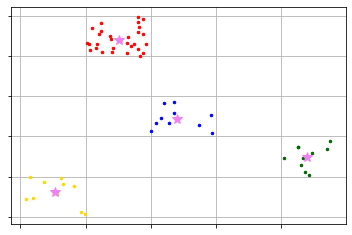

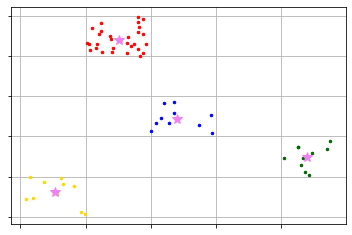

In [27]:
# 参考 https://pyclustering.github.io/docs/0.9.0/html/dd/db4/classpyclustering_1_1cluster_1_1xmeans_1_1xmeans.html
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES
# Read sample 'simple3' from file.
sample = read_sample(SIMPLE_SAMPLES.SAMPLE_SIMPLE3)
# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(sample, amount_initial_centers).initialize()
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(sample, initial_centers, 20)
xmeans_instance.process()
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
# Visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.append_cluster(centers, None, marker='*', markersize=10)
visualizer.show()

In [28]:
df_list = df_data_pct.T.values.tolist() #list(df_data_pct.T.values)

# 固定できない...
np.random.seed(100)
random.seed(100)
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(df_list, amount_initial_centers).initialize()
xmeans_instance = xmeans(df_list, initial_centers, 5)
xmeans_instance.process()
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
clusters

[[0], [3], [1, 2, 4]]

In [29]:
# num_clst = len(clusters)
df_weight = pd.DataFrame([], columns=['budget'], index=target_name)
for clst in clusters:
    for c in clst:
        df_weight.iloc[c] = np.round(1 / len(clst) / len(clusters), 5)
df_weight

,budget
SPBDU10T Index,0.33333
SPXT Index,0.11111
TPXDDVD Index,0.11111
SPJGBTR Index,0.33333
SX5E Index,0.11111


In [30]:
# 参考 https://github.com/jcrichard/pyrb
from pyrb import RiskBudgeting
covariance_matrix = df_data_pct.cov() * 52
budgets = df_weight.values.reshape(-1).tolist()
RB = RiskBudgeting(covariance_matrix, budgets)
RB.solve()
df_weight['weight'] = RB.x
df_weight

,budget,weight
SPBDU10T Index,0.33333,0.278785
SPXT Index,0.11111,0.048596
TPXDDVD Index,0.11111,0.051326
SPJGBTR Index,0.33333,0.581251
SX5E Index,0.11111,0.040041
